In [1]:
%reload_ext autoreload
%autoreload 2

In [17]:
from xai_cola import data_interface 
from xai_cola import ml_model_interface
from counterfactual_explainer import DiCE,DisCount
from xai_cola.cola_policy.matching import CounterfactualExactMatchingPolicy
from xai_cola.counterfactual_limited_actions import COLA

#### 0. Pick the data to be factual("Risk"=1)

In [18]:
from test_dataset.german_credit import GermanCreditDataset
dataset = GermanCreditDataset()
df = dataset.get_dataframe()
df.head(3)

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,0,1,1169,6,5,0
1,22,0,2,1,1,2,5951,48,5,1
2,49,1,1,1,1,0,2096,12,3,0


In [19]:
# pick 4 samples with Risk = 1
df_Risk_1 = df[df['Risk'] == 1]
df_Risk_1 = df_Risk_1.sample(10)

# drop the target column.
# Normally, the input data doesn't contain the target column
df_without_target = df_Risk_1.drop(columns=['Risk']).copy()
feature_names = df_without_target.columns
df_without_target.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
668,43,1,2,2,1,1,4843,12,1
398,46,1,2,2,1,2,1223,12,1
707,25,0,2,2,1,2,2969,12,4
642,40,1,3,1,2,0,4623,15,3
9,28,1,3,1,1,2,5234,30,1


#### 1. Initialize data interface

In [20]:
data = data_interface.PandasData(df_without_target, target_name='Risk')

#### 2. Initialize model interface

In [21]:
import joblib
lgbmcClassifier = joblib.load('lgbm_GremanCredit.pkl')
print(f'----lgbm_GremanCredit.pkl model has been loaded----')

----lgbm_GremanCredit.pkl model has been loaded----


In [22]:
ml_model = ml_model_interface.Model(model=lgbmcClassifier, backend="sklearn")

#### 3.Choose the CounterfactualExplanation Algorithm

In [23]:
explainer = DiCE(ml_model=ml_model)

In [24]:
factual, counterfactual = explainer.generate_counterfactuals(data=data,
                                                             factual_class=1,
                                                             total_cfs=1,
                                                             features_to_keep=['Age','Sex'])

100%|██████████| 10/10 [00:00<00:00, 10.52it/s]


In [25]:
print(f'factual: {factual}')
print(f'counterfactual: {counterfactual}')

factual: [[  43    1    2    2    1    1 4843   12    1]
 [  46    1    2    2    1    2 1223   12    1]
 [  25    0    2    2    1    2 2969   12    4]
 [  40    1    3    1    2    0 4623   15    3]
 [  28    1    3    1    1    2 5234   30    1]
 [  37    0    2    2    1    1 7685   48    0]
 [  30    1    2    0    3    1 3349   24    4]
 [  21    0    2    2    1    0 2570   27    1]
 [  19    0    2    2    1    0 1980    9    4]
 [  28    1    2    1    1    2 3060   48    5]]
counterfactual: [[  43    1    2    2    1    1 7628   11    1]
 [  46    1    2    2    1    2 1490   12    1]
 [  25    0    2    2    3    2 4694   12    4]
 [  40    1    3    1    2    0 5251   15    4]
 [  28    1    3    1    1    2 5234   16    1]
 [  37    0    2    2    1    0 5213   48    0]
 [  30    1    2    1    3    0 3349   24    4]
 [  21    0    2    1    1    0 2570   30    1]
 [  19    0    3    2    1    0 5546    9    4]
 [  28    1    2    1    3    2 3060   24    5]]


#### 4. Choose policy and make limitation

In [26]:
refiner = COLA(
            data=data,
            ml_model=ml_model,
            x_factual=factual,
            x_counterfactual=counterfactual,
            )
refiner.set_policy(
            matcher="ect",
            attributor="pshap",
            Avalues_method="max"
            )

You choose the Policy: pshap With Exact Matching, Avalues_method is max


In [42]:
""" Here! control the limited actions """
factual, ce, ace = refiner.get_refined_counterfactual(limited_actions=12)

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.14029523 0.59880749]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.26519534 0.15250411]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.2290671  0.38397582]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [ 0.51871915 -0.11840092]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.11201537 0.55708262]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.24169406 0.00487437]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.03114633 0.29327096]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.14207368 0.46001238]


#### 5.Highlight the generated counterfactuals

In [43]:
refine_factual, refine_ce, refine_ace = refiner.highlight_changes()

In [51]:
actions = refiner.query_minimum_actions()

The minimum number of actions is 12


In [44]:
print("factual")
display(factual)
print("factaul -> corresponding counterfactual")
display(refine_ce)
print("factual -> action-limited counterfactual")
display(refine_ace)

factual


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,43,1,2,2,1,1,4843,12,1,1
1,46,1,2,2,1,2,1223,12,1,1
2,25,0,2,2,1,2,2969,12,4,1
3,40,1,3,1,2,0,4623,15,3,1
4,28,1,3,1,1,2,5234,30,1,1
5,37,0,2,2,1,1,7685,48,0,1
6,30,1,2,0,3,1,3349,24,4,1
7,21,0,2,2,1,0,2570,27,1,1
8,19,0,2,2,1,0,1980,9,4,1
9,28,1,2,1,1,2,3060,48,5,1


factaul -> corresponding counterfactual


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,43,1,2,2,1,1,4843 -> 7628,12 -> 11,1,1 -> 0
1,46,1,2,2,1,2,1223 -> 1490,12,1,1 -> 0
2,25,0,2,2,1 -> 3,2,2969 -> 4694,12,4,1 -> 0
3,40,1,3,1,2,0,4623 -> 5251,15,3 -> 4,1 -> 0
4,28,1,3,1,1,2,5234,30 -> 16,1,1 -> 0
5,37,0,2,2,1,1 -> 0,7685 -> 5213,48,0,1 -> 0
6,30,1,2,0 -> 1,3,1 -> 0,3349,24,4,1 -> 0
7,21,0,2,2 -> 1,1,0,2570,27 -> 30,1,1 -> 0
8,19,0,2 -> 3,2,1,0,1980 -> 5546,9,4,1 -> 0
9,28,1,2,1,1 -> 3,2,3060,48 -> 24,5,1 -> 0


factual -> action-limited counterfactual


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,43,1,2,2,1,1,4843,12 -> 11,1,1 -> 0
1,46,1,2,2,1,2,1223 -> 1490,12,1,1 -> 0
2,25,0,2,2,1 -> 3,2,2969 -> 4694,12,4,1 -> 0
3,40,1,3,1,2,0,4623 -> 5251,15,3 -> 4,1 -> 0
4,28,1,3,1,1,2,5234,30 -> 16,1,1 -> 0
5,37,0,2,2,1,1 -> 0,7685,48,0,1 -> 0
6,30,1,2,0,3,1 -> 0,3349,24,4,1 -> 0
7,21,0,2,2 -> 1,1,0,2570,27,1,1 -> 0
8,19,0,2,2,1,0,1980 -> 5546,9,4,1 -> 0
9,28,1,2,1,1,2,3060,48 -> 24,5,1 -> 0


changes from factual to counterfactual


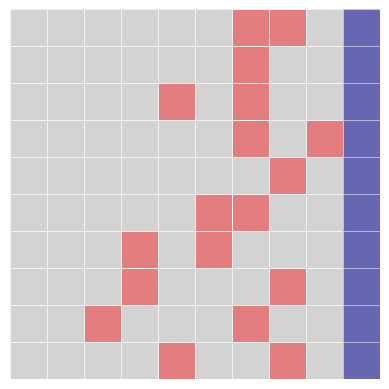

changes from factual to actionlimited_counterfactuals


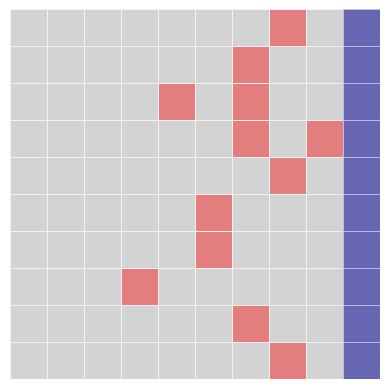

(None, None)

In [45]:
refiner.heatmap()